# Not working currently!

In [1]:
from fastai.vision.all import *
from fastai.vision.gan import *
from unet import Unet
from diffusers import UNet2DModel
from copy import deepcopy

In [2]:
bs = 64
size = 128

In [3]:
path = untar_data(URLs.LSUN_BEDROOMS)

In [4]:
dblock = DataBlock(blocks = (TransformBlock, ImageBlock),
                   get_x = partial(generate_noise, size=(3, size, size)),
                   get_items = get_image_files,
                   splitter = IndexSplitter(list(range(len(get_image_files(path))))[-bs:]),
                   item_tfms=Resize(size, method=ResizeMethod.Crop), 
                   batch_tfms = Normalize.from_stats(torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])))

In [5]:
dls = dblock.dataloaders(path, path=path, bs=bs)

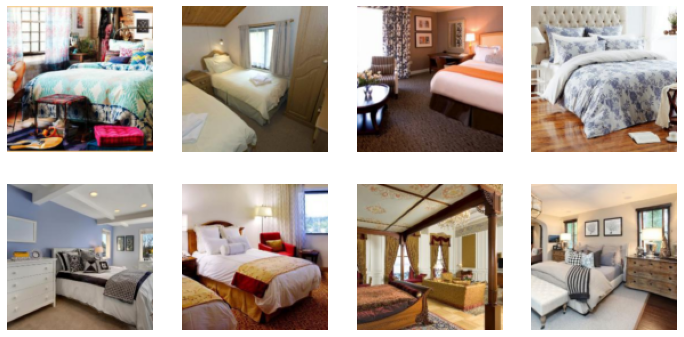

In [6]:
dls.show_batch(max_n=8)

In [7]:
xb, yb = next(iter(dls.train))
assert xb.shape == yb.shape

In [8]:
class ModelEma(nn.Module):
    def __init__(self, model, decay=0.9999, device=None):
        super(ModelEma, self).__init__()
        # make a copy of the model for accumulating moving average of weights
        self.module = deepcopy(model)
        self.module.eval()
        self.decay = decay
        self.device = device  # perform ema on different device from model if set
        if self.device is not None:
            self.module.to(device=device)

    def _update(self, model, update_fn):
        with torch.no_grad():
            for ema_v, model_v in zip(self.module.state_dict().values(), model.state_dict().values()):
                if self.device is not None:
                    model_v = model_v.to(device=self.device)
                ema_v.copy_(update_fn(ema_v, model_v))

    def update(self, model):
        self._update(model, update_fn=lambda e, m: self.decay * e + (1. - self.decay) * m)

    def set(self, model):
        self._update(model, update_fn=lambda e, m: m)

class EMACallback(Callback):
    order,run_valid = MixedPrecision.order+1,False
    "Callback to implment Model Exponential Moving Average from PyTorch Image Models in fast.ai"
    def __init__(self, decay=0.9999, ema_device=None):
        store_attr()

    @torch.no_grad()
    def before_fit(self):
        self.ema_model = ModelEma(self.learn.model, self.decay, self.ema_device)

    def after_batch(self):
        self.ema_model.update(self.learn.model)

    def before_validate(self):
        self.temp_model = self.learn.model
        self.learn.model = self.ema_model.module

    def after_validate(self):
        self.learn.model = self.temp_model

    @torch.no_grad()
    def after_fit(self):
        self.learn.model = self.ema_model.module
        self.ema_model = None
        self.remove_cb(EMACallback)

In [9]:
class DDPMCallback(Callback):
    def __init__(self, n_steps, beta_min, beta_max):
        store_attr()

    def before_fit(self):
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps).to(self.dls.device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.sigma = torch.sqrt(self.beta)


    def before_batch_training(self):
        eps = self.xb[0]
        x0 = self.yb[0]
        batch_size = x0.shape[0]
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long)
        xt =  torch.sqrt(self.alpha_bar[t].reshape(-1, 1, 1, 1))*x0 + TensorImage(torch.sqrt(1-self.alpha_bar[t].reshape(-1, 1, 1, 1))*eps)
        self.learn.xb = (xt, t)
        self.learn.yb = (eps,)


    def before_batch_sampling(self):
        x_t = TensorImage(self.xb[0])
        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((x_t.shape[0],), t, device=x_t.device, dtype=torch.long)
            z = torch.randn(x_t.shape, device=x_t.device) if t > 0 else torch.zeros(x_t.shape, device=x_t.device)
            alpha_t = self.alpha[t_batch].reshape(-1, 1, 1, 1)
            alpha_bar_t = self.alpha_bar[t_batch].reshape(-1, 1, 1, 1)
            sigma_t = self.sigma[t_batch].reshape(-1, 1, 1, 1)
            x_t = 1/torch.sqrt(alpha_t) * (x_t - (1-alpha_t)/torch.sqrt(1-alpha_bar_t) * self.learn.model(x_t, t_batch))  + sigma_t*z
        self.learn.pred = (x_t,)
        raise CancelBatchException

    def before_batch(self):
        if self.training: self.before_batch_training()
        else: self.before_batch_sampling()


In [10]:
model = Unet(dim=64)

In [11]:
ddpm_learner = Learner(dls, model, cbs=[DDPMCallback(n_steps=1000, beta_min=0.0001, beta_max=0.02)], loss_func=MSELossFlat())

SuggestedLRs(valley=3.0199516913853586e-05)

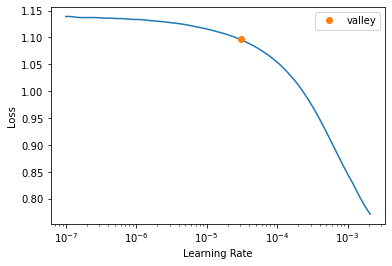

In [12]:
ddpm_learner.lr_find()

In [13]:
ddpm_learner.fit(1,1e-4, cbs=[EMACallback()])

epoch,train_loss,valid_loss,time
0,0.015826,0.014151,36:11


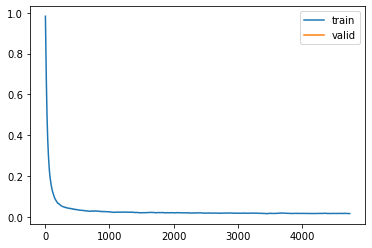

In [14]:
ddpm_learner.recorder.plot_loss()

In [15]:
preds = ddpm_learner.get_preds()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


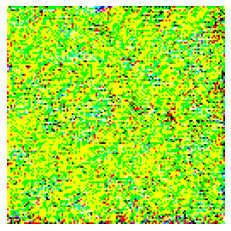

In [16]:
preds[0][1].show()

In [17]:
eps = ddpm_learner.xb[0]
x0 = ddpm_learner.yb[0]
batch_size = x0.shape[0]
t = torch.randint(0, ddpm_learner.ddpm.n_steps, (batch_size,), device=x0.device, dtype=torch.long)
xt =  torch.sqrt(ddpm_learner.ddpm.alpha_bar[t].reshape(-1, 1, 1, 1))*x0 + TensorImage(torch.sqrt(1-ddpm_learner.ddpm.alpha_bar[t].reshape(-1, 1, 1, 1))*eps)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


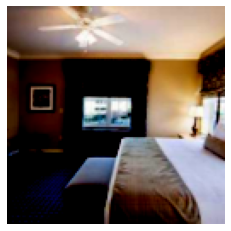

In [35]:
x0[59].show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


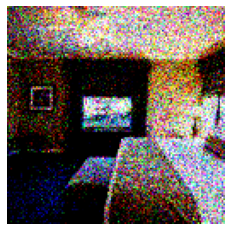

In [36]:
xt[59].show()

In [20]:
x0hat = (xt - torch.sqrt(1-ddpm_learner.ddpm.alpha_bar[t].reshape(-1, 1, 1, 1))*ddpm_learner.model(xt,t))/torch.sqrt(ddpm_learner.ddpm.alpha_bar[t].reshape(-1, 1, 1, 1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


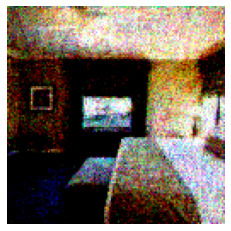

In [37]:
x0hat[59].show()